## ch16 Training for different metrics
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.8.8</div>
<div style="text-align: right"> Last update: 2023.8.8</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
from xg_helpers import my_dot_export

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

### 16.2 Training with Validation Curves

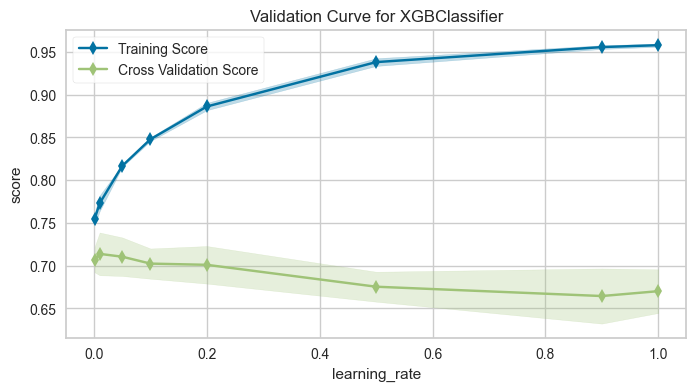

In [9]:
from yellowbrick import model_selection as ms

fig, ax = plt.subplots(figsize = (8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train,
                    scoring='accuracy', param_name='learning_rate',
                    param_range=[0.001, .01, .05, .1, .2, .5, .9, 1], ax=ax
                    )
ax.set_label('Accuracy')

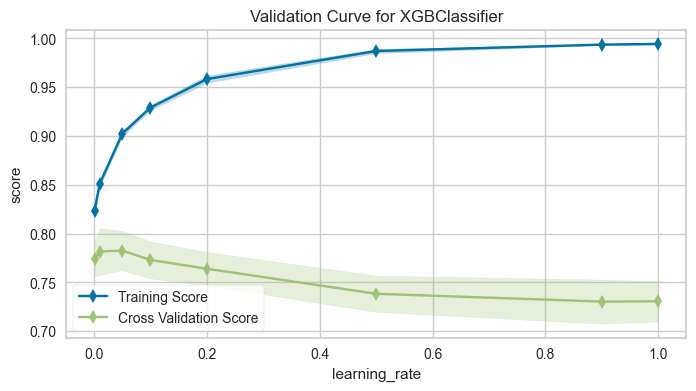

Text(0.5, 24.140625, 'roc_auc')

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_train, y_train,
scoring='roc_auc', param_name='learning_rate',
param_range=[0.001, .01, .05, .1, .2, .5, .9, 1], ax=ax
)
ax.set_xlabel('roc_auc')

### 16.3 Step-wise Recall Tuning

In [11]:
from sklearn.metrics import roc_auc_score
from hyperopt import hp, Trials, fmin, tpe

params = {'random_state': 42}
rounds = [{'max_depth': hp.quniform('max_depth', 1, 9, 1), # tree
'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
{'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
{'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
{'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
]

In [12]:
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: xhelp.hyperparameter_tuning(
        space, X_train, y_train, X_test, y_test, metric=roc_auc_score),
        space=params,           
        algo=tpe.suggest,            
        max_evals=40,            
        trials=trials,
    )
    params = {**params, **best}
    

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 40/40 [00:04<00:00,  9.47trial/s, best loss: -0.7696272545484992]


In [13]:
params

{'random_state': 42,
 'max_depth': 4.0,
 'min_child_weight': 10.348285075547283,
 'subsample': 0.7973176999616614,
 'colsample_bytree': 0.6893371225015752,
 'gamma': 0.0002498068810001,
 'learning_rate': 0.1880964872541906}

기본모델과 최적화된 모델을 비교해보자.

In [14]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)
metrics.roc_auc_score(y_test, xgb_def.predict(X_test))

0.7451313573096131

In [15]:
params = {'random_state': 42,
 'max_depth': 6, # 정수로 수정
 'min_child_weight': 0.2108347839991595,
 'subsample': 0.8854405583101347,
 'colsample_bytree': 0.6065769876844334,
 'gamma': 1.9673199985831995,
 'learning_rate': 0.1059500750163762}

In [16]:
xgb_tuned = xgb.XGBClassifier(**params, early_stopping_rounds = 50,
                              n_estimators = 500)
xgb_tuned.fit(X_train, y_train, eval_set = [(X_train, y_train),
                                            (X_test, y_test)], verbose = 100)

[0]	validation_0-logloss:0.66997	validation_1-logloss:0.66965
[100]	validation_0-logloss:0.44370	validation_1-logloss:0.49604
[145]	validation_0-logloss:0.42887	validation_1-logloss:0.49551


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6065769876844334, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.9673199985831995, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1059500750163762, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=0.2108347839991595, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)